# Test for functionality of inverse convariance routine with gpu-zeropad code

Also comparison to corrcal algo of determinant correctness.

##### Module imports

In [24]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.insert(0, str(parent_dir))

In [25]:
import numpy as np
import cupy as cp
import seaborn as sns
from zp_puregpu_funcs_py import *
from invcov import *

##### Simulation parameters. ie. noise, diffuse, and source matrices with correct matrix shapes + edges array.

In [26]:
#the main parametes describing our problem.
n_bl = 30
n_eig = 3
n_src = 5
xp = cp  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 4))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
sim_noise_mat = xp.random.rand(n_bl, dtype = 'float64')**2   #in principle this is squared since is a variance
sim_diff_mat = xp.random.rand(n_bl, n_eig, dtype = 'float64')
sim_src_mat = xp.random.rand(n_bl, n_src, dtype = 'float64')

The edges of the redundant blocks have indices[ 0  3  5 17 24 30]


##### We zeropad the matrices first, then return the inverse covariance

In [27]:
#zeropad the noise, diff, source mats
zp_sim_noise_mat_inv, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=True)  #return inverse set to True to get around div by 0 issue
zp_sim_noise_mat, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=False)  #return inverse set to False for sims later on
zp_sim_diff_mat, largest_block, n_blocks = zeroPad(sim_diff_mat, edges, return_inv=False)
zp_sim_src_mat, largest_block, n_blocks = zeroPad(sim_src_mat, edges, return_inv=False)

#Need to reshape to give an extra dimension of n_blocks to be compatible with inv cov routine
sim_noise_mat_2d = zp_sim_noise_mat_inv.reshape(n_blocks, largest_block)   #Again, its worth noting the values of the noise mat are really 1/noise_vals here
sim_diff_mat_3d = zp_sim_diff_mat.reshape(n_blocks, largest_block, n_eig)
sim_src_mat_3d = zp_sim_src_mat.reshape(n_blocks, largest_block, n_src)

In [28]:
#find inverse components, noting the result will still be a set of zeropadded matrices
#Note we feed the inverse noise components to the inverse cov routine as can be seen by the N_is_inv=True
logdet, N_inv, Del_p, Sig_p = inverse_covariance(sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges=edges, xp = xp , ret_det = True, N_is_inv=True)

In [29]:
print(logdet)

153.08108956481522


The shapes of the output matrices remain in the form wherein n_blocks is one of the dimensions. In order to use the sparse to dense function, and more easily perform checks that the inverce components we calculated are indeed the correct ones, it is useful to reshape back to the original simulated shapes.

In [30]:
N_inv = N_inv.reshape(n_blocks*largest_block)
Del_p = Del_p.reshape(n_blocks*largest_block, n_eig)
Sig_p = Sig_p.reshape(n_blocks*largest_block, n_src)

In [31]:
#convert sparse things to dense things to visualize what we're really working with
sim_diff_mat_dense = sparden_convert(zp_sim_diff_mat, largest_block, n_blocks, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp, zeroPad=True)
Del_p_dense = sparden_convert(Del_p, largest_block, n_blocks, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp, zeroPad=True)

##### At this point, we are set up to visualize the dense version of the diffuse matrix

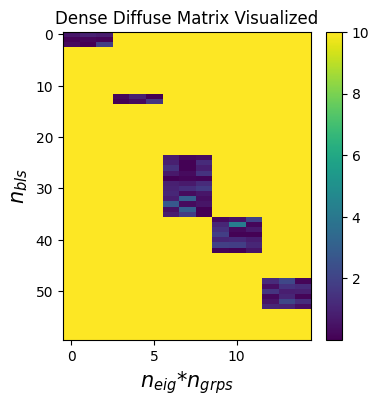

In [32]:
#using the original simulated diffuse matrix
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cp.asnumpy(cp.log(sim_diff_mat_dense + 1e-20)*-1), vmax = 10, cmap='viridis', aspect='auto')
ax.set_title("Dense Diffuse Matrix Visualized")
ax.set_xlabel("$n_{eig}$*$n_{grps}$", fontsize = 15)
ax.set_ylabel("$n_{bls}$", fontsize = 15)
fig.colorbar(im)
plt.show()

#would like the center to be at 0, vmin and vmax only differ by a sign

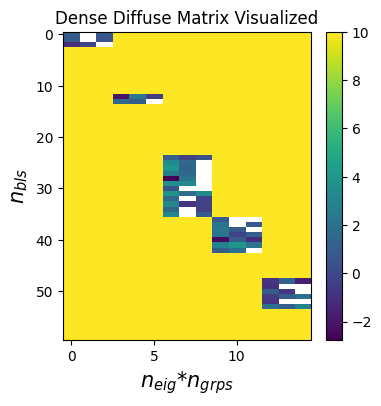

In [33]:
#Using the \delta' matrix, note it should have the same shape as the simulated matrix
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cp.asnumpy(cp.log(Del_p_dense + 1e-20)*-1), vmax = 10, cmap='viridis', aspect='auto')
ax.set_title("Dense Diffuse Matrix Visualized")
ax.set_xlabel("$n_{eig}$*$n_{grps}$", fontsize = 15)
ax.set_ylabel("$n_{bls}$", fontsize = 15)
fig.colorbar(im)
plt.show()

Recall that the noise matrix has a shape $n_{bl} \times n_{bl}$, the source matrix has a shape $n_{src} \times n_{src}$, while the diffuse matrix in its dense form has a shape $n_{bl} \times n_{bl}$. After eigen-decomp of the diffuse matrix, however, the diffuse matrix is block diagonal and we only end up storign the non-zero bits. Therefore, in the code that follows it is important to use the dense (original) form of the diffuse matrix, even though we can use the noise matrix and the source matrix in the way they were originally simulated. 

<Axes: >

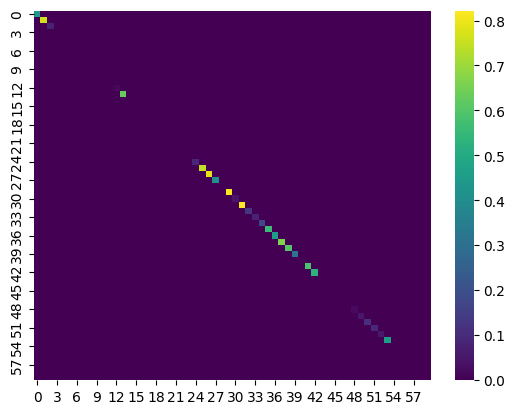

In [34]:
sns.heatmap(cp.asnumpy(cp.diag(zp_sim_noise_mat)), cmap='viridis')

<Axes: >

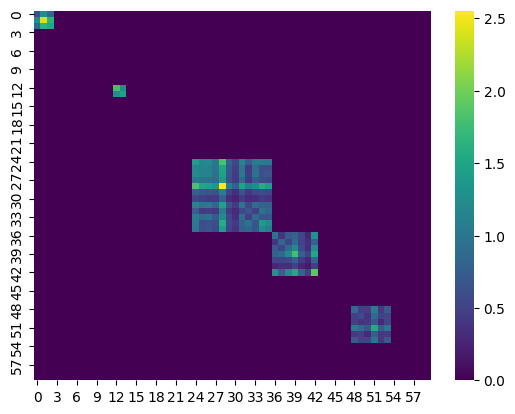

In [35]:
sns.heatmap(cp.asnumpy((sim_diff_mat_dense@sim_diff_mat_dense.T)), cmap='viridis')

<Axes: >

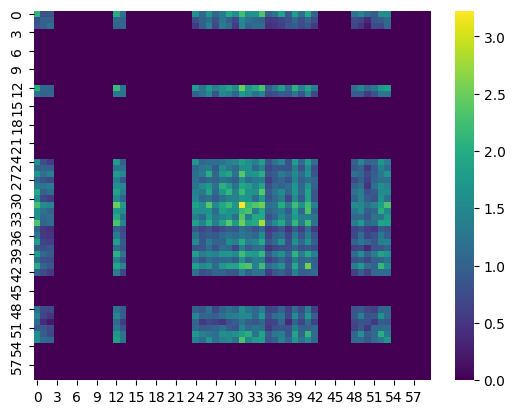

In [36]:
sns.heatmap(cp.asnumpy((zp_sim_src_mat@zp_sim_src_mat.T)), cmap='viridis')

In [37]:
#First we assemble te dense covariance object using the input matrices above (all zp'd of course)
C = xp.diag(zp_sim_noise_mat) + sim_diff_mat_dense@sim_diff_mat_dense.T + zp_sim_src_mat@zp_sim_src_mat.T

#Now we do the same with the inverse covariance components
C_inv = xp.diag(N_inv) - Del_p_dense@Del_p_dense.T - Sig_p@Sig_p.T

#now check their matrix product returns the identity
if np.allclose(C@C_inv, np.eye(C.shape[0])) == True:
    print("C*C^{-1} returns the identity")

#brute force computation of C^{-1} using numpy
C_numpy_inv = cp.linalg.inv(C)

#check the answer is the same as C = N + Del * Del^dag + Sig * Sig^dag 
if np.allclose(C_inv, C_numpy_inv) == True:
    print("Brute force computation with numpy returns the same answer as our sparse 2-level inverse routine")


<Axes: >

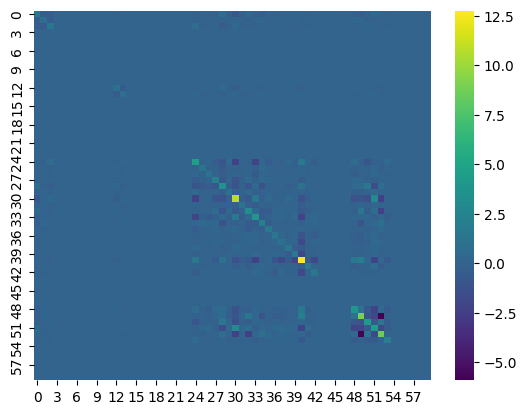

In [38]:
sns.heatmap(cp.asnumpy(C_inv), cmap='viridis')

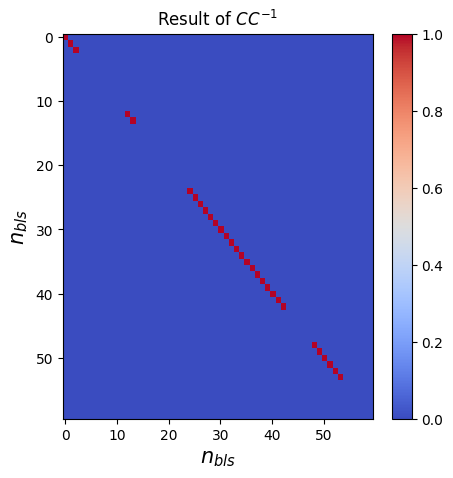

In [39]:
fig, ax = plt.subplots(figsize = (5,5))
im = ax.imshow(cp.asnumpy(C@C_inv), cmap = 'coolwarm', aspect='auto')
ax.set_title("Result of $CC^{-1}$")
ax.set_xlabel("$n_{bls}$", fontsize = 15)
ax.set_ylabel("$n_{bls}$", fontsize = 15)
fig.colorbar(im)
plt.show()

### Undo zeropadding

Let's retest things without the zeropadding

In [40]:
zp_sim_noise_mat = zp_sim_noise_mat.reshape(n_blocks, largest_block)
zp_sim_diff_mat = zp_sim_diff_mat.reshape(n_blocks, largest_block, n_eig)
zp_sim_src_mat = zp_sim_src_mat.reshape(n_blocks, largest_block, n_src)
N_inv = N_inv.reshape(n_blocks, largest_block)
Del_p = Del_p.reshape(n_blocks, largest_block, n_eig)
Sig_p = Sig_p.reshape(n_blocks, largest_block, n_src)

In [41]:
zp_sim_noise_mat = undo_zeropad(zp_sim_noise_mat, edges, cp)
zp_sim_diff_mat = undo_zeropad(zp_sim_diff_mat, edges, cp)
zp_sim_src_mat = undo_zeropad(zp_sim_src_mat, edges, cp)
N_inv = undo_zeropad(N_inv, edges, cp)
Del_p = undo_zeropad(Del_p, edges, cp)
Sig_p = undo_zeropad(Sig_p, edges, cp)

In [42]:
#convert sparse things to dense things to visualize what we're really working with
sim_diff_mat_dense = sparden_convert(zp_sim_diff_mat, largest_block, n_blocks, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp, zeroPad=False)
Del_p_dense = sparden_convert(Del_p, largest_block, n_blocks, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp, zeroPad=False)

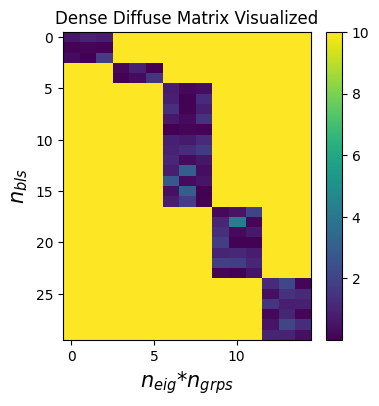

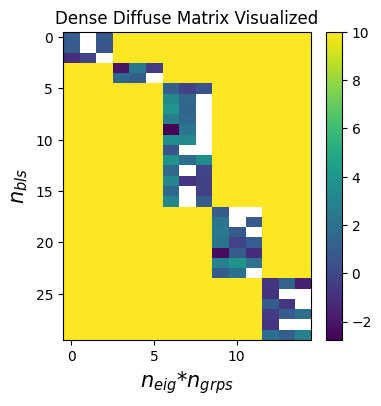

In [43]:
#using the original simulated diffuse matrix
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cp.asnumpy(cp.log(sim_diff_mat_dense + 1e-20)*-1), vmax = 10, cmap='viridis', aspect='auto')
ax.set_title("Dense Diffuse Matrix Visualized")
ax.set_xlabel("$n_{eig}$*$n_{grps}$", fontsize = 15)
ax.set_ylabel("$n_{bls}$", fontsize = 15)
fig.colorbar(im)
plt.show()

#Using the \delta' matrix, note it should have the same shape as the simulated matrix
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cp.asnumpy(cp.log(Del_p_dense + 1e-20)*-1), vmax = 10, cmap='viridis', aspect='auto')
ax.set_title("Dense Diffuse Matrix Visualized")
ax.set_xlabel("$n_{eig}$*$n_{grps}$", fontsize = 15)
ax.set_ylabel("$n_{bls}$", fontsize = 15)
fig.colorbar(im)
plt.show()

In [44]:
#First we assemble te dense covariance object using the input matrices above (all zp'd of course)
C = xp.diag(zp_sim_noise_mat) + sim_diff_mat_dense@sim_diff_mat_dense.T + zp_sim_src_mat@zp_sim_src_mat.T

#Now we do the same with the inverse covariance components
C_inv = xp.diag(N_inv) - Del_p_dense@Del_p_dense.T - Sig_p@Sig_p.T

#now check their matrix product returns the identity
if np.allclose(C@C_inv, np.eye(C.shape[0])) == True:
    print("C*C^{-1} returns the identity")

#brute force computation of C^{-1} using numpy
C_numpy_inv = cp.linalg.inv(C)

#check the answer is the same as C = N + Del * Del^dag + Sig * Sig^dag 
if np.allclose(C_inv, C_numpy_inv) == True:
    print("Brute force computation with numpy returns the same answer as our sparse 2-level inverse routine")


C*C^{-1} returns the identity
Brute force computation with numpy returns the same answer as our sparse 2-level inverse routine


<Axes: >

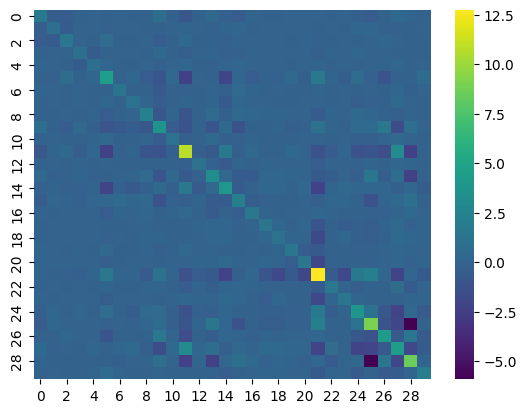

In [45]:
sns.heatmap(cp.asnumpy(C_inv), cmap='viridis')

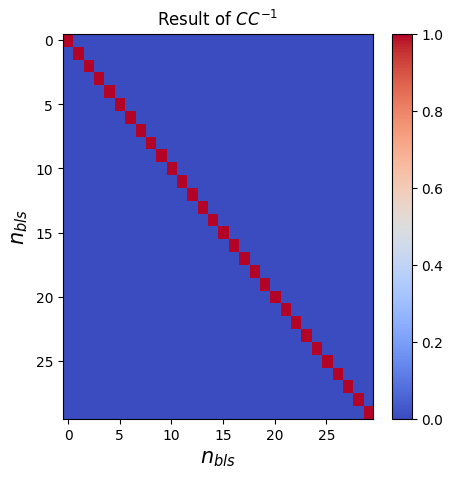

In [46]:
fig, ax = plt.subplots(figsize = (5,5))
im = ax.imshow(cp.asnumpy(C@C_inv), cmap = 'coolwarm', aspect='auto')
ax.set_title("Result of $CC^{-1}$")
ax.set_xlabel("$n_{bls}$", fontsize = 15)
ax.set_ylabel("$n_{bls}$", fontsize = 15)
fig.colorbar(im)
plt.show()